In [1]:
import numpy as np
import cv2 as cv2
import pandas as pd
import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
pd.set_option('max_rows', None)

In [2]:
##!pip install opencv-python

**Loading Dataset And Generate Data Matrix**

In [2]:
global personNumber
personNumber=1
global pictureNumber
pictureNumber=1
dataMatrix=np.empty((0,10304),int)
for i in range(400):
    path='ORL/s'+str(personNumber)+'/'+str(pictureNumber)+'.jpg'
    img=Image.open(path)
    data=np.asarray(img)
    data=data.reshape(1,10304)
    dataMatrix = np.append(dataMatrix, np.array(data), axis=0)
    pictureNumber+=1
    if(pictureNumber==11):
        personNumber+=1
        pictureNumber=1
df_alldata=pd.DataFrame(dataMatrix)

**Generate Label Vector**

In [3]:
label=np.arange(1,41)
labelVector=np.repeat(label,10)

**Split Train And Test data**

In [4]:
trainData=dataMatrix[1::2,:] 
testData=dataMatrix[::2,:]
df_train=pd.DataFrame(trainData)
df_test=pd.DataFrame(testData)

**Split Label Vector**

In [5]:
label_trainData=labelVector[1::2] 
label_testData=labelVector[::2]
df_labeltrain=pd.DataFrame(label_trainData)
df_labeltest=pd.DataFrame(label_testData)

**PCA**

In [6]:
def pca(x,alpha):
    varianceList=list()
    basis=list()
    meanVector=np.mean(x,axis=0)
    z=x-meanVector
    cov=z.T.dot(x)/200
    eigenValue,eigenVector=np.linalg.eigh(cov)
    eigenVal=np.sort(eigenValue)[::-1]
    eigenVec=eigenVector[:,np.argsort(eigenValue)[::-1]]
    for i in range(1,len(eigenVal)+1,1):
        varianceList.append(sum(eigenVal[0:i])/np.sum(eigenVal))
    for y in range(len(alpha)):
        r_min=min(i for i in varianceList if i >= alpha[y])
        result=varianceList.index(r_min)+1
        basis.append(result)   
    return basis,eigenVec

**LDA**

In [7]:
def MLDA(x,numSample,flag):
    ldaMeanVector = list()
    M = list()
    SW = 0
    SB = 0
    centroid = np.mean(x,axis=0)
    for i in range(0,len(x),numSample):
        M.append((x[i:i+numSample]))
               
    for i in range(len(M)):
        ldaMeanVector.append(np.mean(M[i],axis=0))  ## From M1 To M40
    ldaMeanVector = np.array(ldaMeanVector)
    
    for i in range(len(M)):
        SW +=  ( (M[i] - ldaMeanVector[i]).T).dot( M[i]-ldaMeanVector[i] )
    
    if flag == 1:
        for i in range(len(M)):
            z = ldaMeanVector[i] - centroid
            zT = z.reshape(z.shape+(1,))
            SB +=  numSample * ( (zT).dot(np.matrix(z)) )        
    else:
        z = ldaMeanVector[1]-ldaMeanVector[0]
        zT = z.reshape(z.shape+(1,))
        SB = (zT).dot(np.matrix(z))
        
    dominantVectors = len(M)
    s_inverse = np.linalg.inv(SW)
    eigenValue,eigenVector = np.linalg.eigh(s_inverse.dot(SB))
    eigenVal = np.sort(eigenValue)[::-1]
    eigenVec = eigenVector[:,np.argsort(eigenValue)[::-1]]
    return eigenVec[:,0:dominantVectors]

**KNN**

In [8]:
def knn(x_train,y_train,x_test,y_test,k):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(x_train,y_train)
    test_accuracy= classifier.score(x_test, y_test)
    y_pred = classifier.predict(x_test)
    return y_pred,test_accuracy

**KNN Accuracy Classifier Tuning**

In [9]:
def knnAccuracy(x_train,y_train,x_test,y_test):
    neighbors=[1,3,5,7]
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    for i, k in enumerate(neighbors):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(x_train,y_train)
        train_accuracy[i] = classifier.score(x_train, y_train)
        test_accuracy[i] = classifier.score(x_test, y_test)
    plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
    plt.legend()
    plt.xlabel('N_Neighbors')
    plt.ylabel('Accuracy')
    plt.show()

**PCA Projection Matrix**

In [10]:
def proMatr(basis,eigenVector,trainData,testData,label_trainData,label_testData):
    prediction=pd.DataFrame()
    acc=list()
    for i in range(len(basis)):
        projectedTest=np.dot(testData,eigenVector[:,0:basis[i]])    
        projectedTrain=np.dot(trainData,eigenVector[:,0:basis[i]]) 
        y_pred,acuuracy=knn(projectedTrain,label_trainData,projectedTest,label_testData,1)
        print("AT ALPHA = ",alpha[i])
        knnAccuracy(projectedTrain,label_trainData,projectedTest,label_testData)  
        acc.append(acuuracy)
        prediction["alpha="+str(alpha[i])]=y_pred
    prediction["True Label"]=label_testData
    return prediction,acc

**Ploting Accuracy Against NonFaces**

In [11]:
def plot(x,alpha):
    plt.plot(x,[200,100,50])
    plt.xlabel('Accuracy')
    plt.ylabel('N-nonFaces')
    if(alpha!=0):
        plt.title('At Alpha='+str(alpha))
    plt.show()

**PCA Solution**

In [12]:
def pcaSolution(trainData,testData,label_trainData,label_testData,alpha):
    basis,eigenVector=pca(trainData,alpha)
    prediction,acc=proMatr(basis,eigenVector,trainData,testData,label_trainData,label_testData)
    print("AT K=1")
    for i in range(len(alpha)):print("Alpha= "+str(alpha[i])+" Accuracy= "+str(acc[i]))
    return prediction,acc

**LDA Solution**

In [13]:
def ldaSolution(trainData,testData,label_trainData,label_testData,noOfSample,flag):
    w = MLDA(trainData,noOfSample,flag)
    print(w)
    projTrain = trainData.dot(w)
    projTest = testData.dot(w)
    pre,accuracy = knn(projTrain,label_trainData,projTest,label_testData,1)
    knnAccuracy(projTrain,label_trainData,projTest,label_testData)
    print("Accuracy= ",accuracy)
    predictionLDA=pd.DataFrame({'Prediction' : pre,
                 'True Label': label_testData})
    return predictionLDA,accuracy

In [16]:
alpha=[0.80,0.85,0.90,0.95]

**PCA Solution With 5 Sample Test And 5 Sample Train Per Person**

AT ALPHA =  0.8


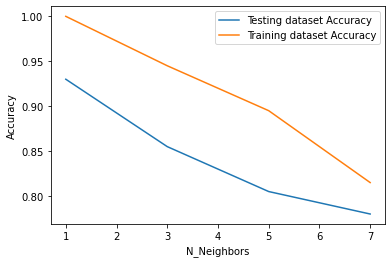

AT ALPHA =  0.85


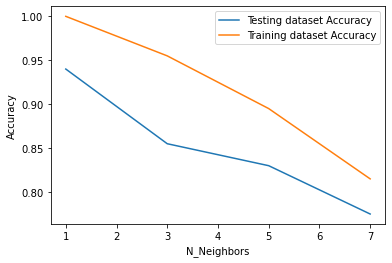

AT ALPHA =  0.9


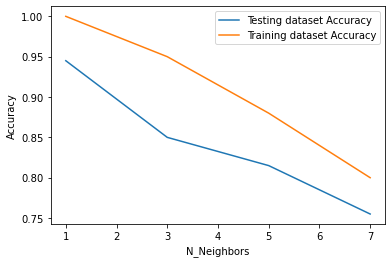

AT ALPHA =  0.95


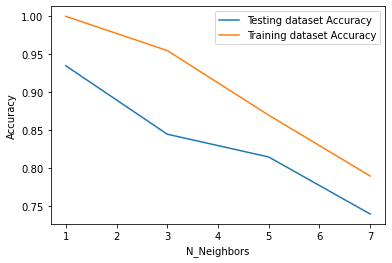

AT K=1
Alpha= 0.8 Accuracy= 0.93
Alpha= 0.85 Accuracy= 0.94
Alpha= 0.9 Accuracy= 0.945
Alpha= 0.95 Accuracy= 0.935


,alpha=0.8,alpha=0.85,alpha=0.9,alpha=0.95,True Label
0,16,16,16,16,1
1,2,19,2,2,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
5,2,2,2,2,2
6,2,2,2,2,2
7,2,2,2,2,2
8,2,2,2,2,2
9,2,2,2,2,2


In [17]:
predection_5,acc_5=pcaSolution(trainData,testData,label_trainData,label_testData,alpha)
predection_5

As We See Above When Value Of Alpha Increase Prediction Accuracy Also Increase With K=1

**LDA Solution With 5 Sample Test And 5 Sample Train Per Person**

[[ 0.00613684 -0.01360128  0.0126416  ... -0.02848185  0.03227332
  -0.0201455 ]
 [ 0.00610804 -0.01306785  0.01239213 ... -0.03181996  0.03575934
  -0.02202236]
 [ 0.00645362 -0.01371116  0.01298616 ... -0.03015421  0.03332275
  -0.02049775]
 ...
 [-0.00029617 -0.01239844 -0.00340319 ... -0.00408755 -0.00486264
  -0.02323935]
 [-0.00840805 -0.01424723 -0.00215213 ... -0.00446666 -0.00715967
  -0.02114045]
 [ 0.00217472 -0.0215503  -0.00521551 ... -0.00738568 -0.01224752
  -0.03431427]]


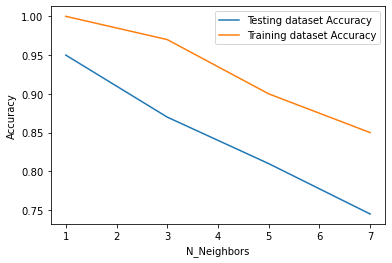

Accuracy=  0.95


,Prediction,True Label
0,16,1
1,1,1
2,1,1
3,1,1
4,1,1
5,2,2
6,2,2
7,2,2
8,2,2
9,2,2


In [18]:
pred_5,accuracy_5=ldaSolution(trainData,testData,label_trainData,label_testData,5,1)
pred_5

**Randomly Split Data In To 7 Instance For Trianing And 3 For Testing**

In [19]:
X_train, X_test,y_train,y_test=train_test_split(dataMatrix,labelVector,test_size=0.3,stratify=labelVector)

**PCA Solution**

AT ALPHA =  0.8


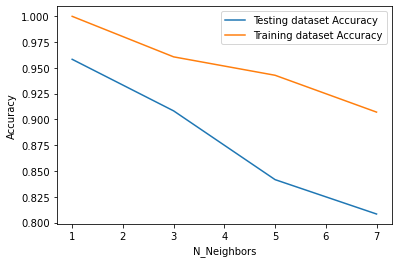

AT ALPHA =  0.85


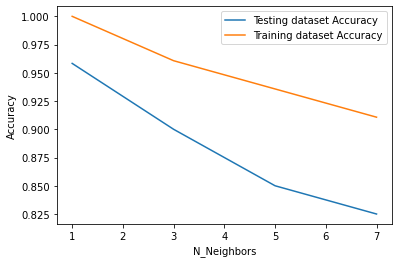

AT ALPHA =  0.9


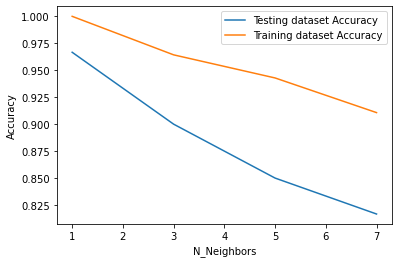

AT ALPHA =  0.95


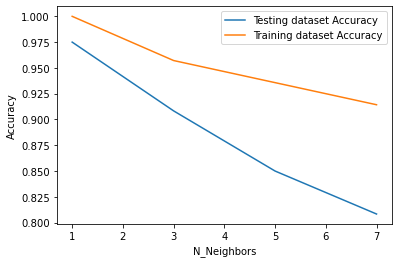

AT K=1
Alpha= 0.8 Accuracy= 0.9583333333333334
Alpha= 0.85 Accuracy= 0.9583333333333334
Alpha= 0.9 Accuracy= 0.9666666666666667
Alpha= 0.95 Accuracy= 0.975


,alpha=0.8,alpha=0.85,alpha=0.9,alpha=0.95,True Label
0,31,31,31,31,31
1,38,38,38,38,38
2,3,3,3,3,3
3,9,9,9,9,9
4,27,27,27,27,27
5,37,37,37,37,37
6,14,14,14,14,14
7,40,40,40,5,40
8,36,36,36,36,36
9,2,2,2,2,2


In [35]:
predection_7,acc_7=pcaSolution(X_train,X_test,y_train,y_test,alpha)
predection_7

**LDA Solution**

[[-0.00968014 -0.00630158  0.00168568 ... -0.0048967   0.0110366
  -0.02861633]
 [-0.01114326 -0.00655163  0.00028501 ... -0.00817517  0.01460841
  -0.03640459]
 [-0.01054795 -0.00615987  0.000755   ... -0.00618197  0.01284926
  -0.03236514]
 ...
 [-0.00302319  0.00449436 -0.00351825 ...  0.00584868  0.00197117
   0.00533683]
 [-0.0015493   0.00904258 -0.00136869 ... -0.00795437  0.00417885
   0.00718025]
 [-0.00120653  0.00034097  0.00934586 ... -0.00803035  0.0077581
  -0.00284635]]


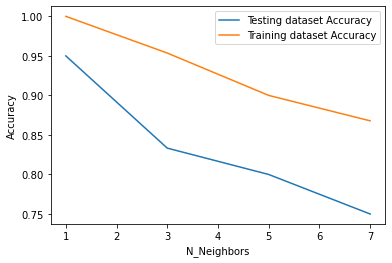

Accuracy=  0.95


,Prediction,True Label
0,31,31
1,38,38
2,3,3
3,9,9
4,27,27
5,37,37
6,14,14
7,40,40
8,36,36
9,2,2


In [20]:
pred_7,accuracy_7=ldaSolution(X_train, X_test,y_train,y_test,7,1)
pred_7

**Loading Non Faces Image And Generating Class Label 0**

In [21]:
nonFacesData=np.empty((0,10304),int)
for pic in glob.glob('nonFaces'+ "/"+"*.jpg"):
    img = cv2.imread(pic,cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img, (92,112), interpolation = cv2.INTER_AREA)
    img = np.array(img)
    vec = img.ravel()
    nonFacesData = np.append(nonFacesData , vec)
nonFacesData=np.reshape(nonFacesData,(400,10304))   
nonFaceLabel=np.array([0])
nonFaceLabel=np.repeat(nonFaceLabel,400)   

**Generating Class Label 1 For Faces Image**

In [22]:
faceLabel=np.array([1])
faceLabel=np.repeat(faceLabel,400)

**Spliting Test And Train Data**

In [23]:
FaceTrain=dataMatrix[1::2,:] 
FaceTest=dataMatrix[::2,:]
label_Facetrain=faceLabel[1::2] 
label_Facetest=faceLabel[::2]

nonFaceTrain=nonFacesData[1::2,:] 
nonFaceTest=nonFacesData[::2,:]
label_nonFacetrain=nonFaceLabel[1::2] 
label_nonFacetest=nonFaceLabel[::2]

**Train Data With 200 Face And 200 Non Face And Test Data With 200 Face And 200 Non Face**

In [24]:
Dtrain_200=np.concatenate((FaceTrain, nonFaceTrain[0:200,:]), axis=0)
Dtest_200=np.concatenate((FaceTest,nonFaceTest), axis=0)

Ltrain_200=np.concatenate((label_Facetrain,label_nonFacetrain), axis=0)
Ltest_200=np.concatenate((label_Facetest,label_nonFacetest), axis=0)

**PCA Solution**

AT ALPHA =  0.8


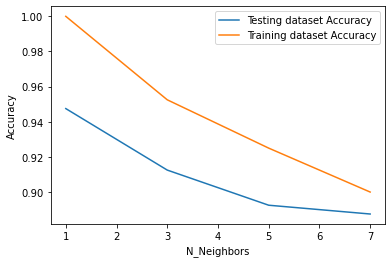

AT ALPHA =  0.85


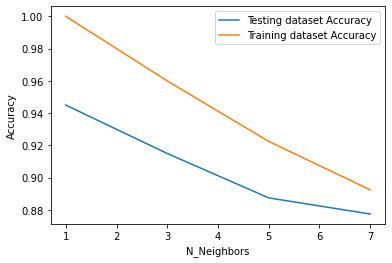

AT ALPHA =  0.9


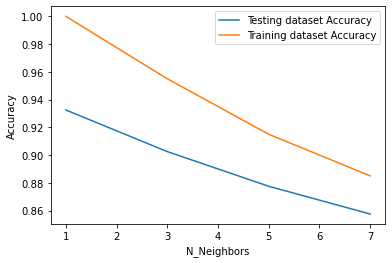

AT ALPHA =  0.95


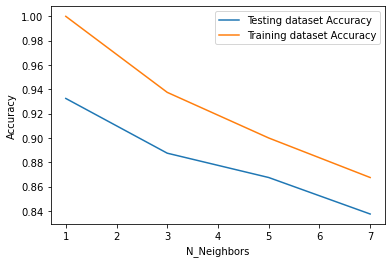

AT K=1
Alpha= 0.8 Accuracy= 0.9475
Alpha= 0.85 Accuracy= 0.945
Alpha= 0.9 Accuracy= 0.9325
Alpha= 0.95 Accuracy= 0.9325


,alpha=0.8,alpha=0.85,alpha=0.9,alpha=0.95,True Label
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,1,1,1
8,1,1,1,1,1
9,1,1,1,1,1


In [25]:
predection_200,acc_200=pcaSolution(Dtrain_200, Dtest_200,Ltrain_200,Ltest_200,alpha)
predection_200

**LDA Solution**

[[ 0.01357402 -0.02112307]
 [ 0.01388648 -0.02163536]
 [ 0.01360316 -0.02116908]
 ...
 [ 0.00412491  0.0028744 ]
 [-0.00380303 -0.00264967]
 [-0.0025095  -0.00174841]]


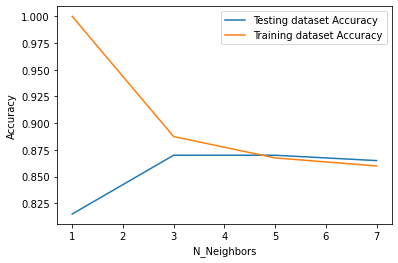

Accuracy=  0.815


,Prediction,True Label
0,0,1
1,0,1
2,0,1
3,1,1
4,1,1
5,1,1
6,1,1
7,0,1
8,1,1
9,1,1


In [26]:
pred_200,accuracy_200=ldaSolution(Dtrain_200, Dtest_200,Ltrain_200,Ltest_200,200,0)
pred_200

**Train Data With 200 Face And 100 Non Face And Test Data With 200 Face And 200 Non Face**

In [27]:
Dtrain_100=np.concatenate((FaceTrain, nonFaceTrain[0:100,:]), axis=0)
Dtest_100=np.concatenate((FaceTest,nonFaceTest), axis=0)

Ltrain_100=np.concatenate((label_Facetrain,label_nonFacetrain[0:100]), axis=0)
Ltest_100=np.concatenate((label_Facetest,label_nonFacetest), axis=0)

**PCA Solution**

AT ALPHA =  0.8


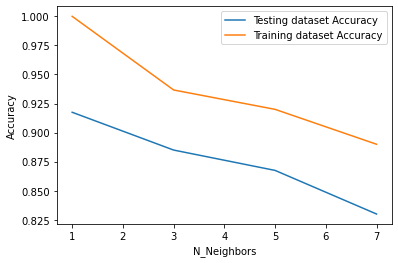

AT ALPHA =  0.85


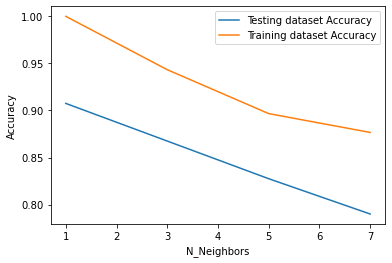

AT ALPHA =  0.9


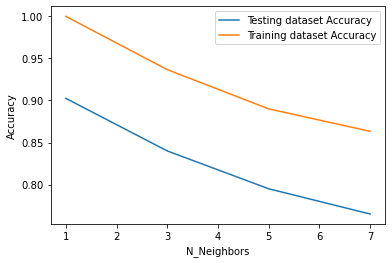

AT ALPHA =  0.95


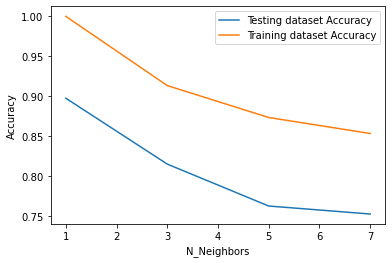

AT K=1
Alpha= 0.8 Accuracy= 0.9175
Alpha= 0.85 Accuracy= 0.9075
Alpha= 0.9 Accuracy= 0.9025
Alpha= 0.95 Accuracy= 0.8975


,alpha=0.8,alpha=0.85,alpha=0.9,alpha=0.95,True Label
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,1,1,1
8,1,1,1,1,1
9,1,1,1,1,1


In [28]:
predection_100,acc_100=pcaSolution(Dtrain_100, Dtest_100,Ltrain_100,Ltest_100,alpha)
predection_100

**LDA Solution**

[[ 0.00614556 -0.00553602]
 [ 0.00657296 -0.0059238 ]
 [ 0.00621567 -0.00559428]
 ...
 [ 0.00246365  0.00286162]
 [-0.00053599 -0.00062217]
 [ 0.00276493  0.00321146]]


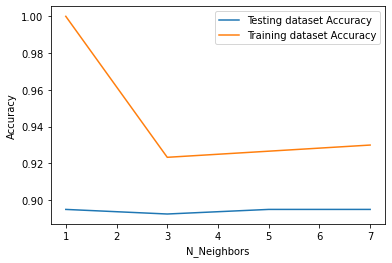

Accuracy=  0.895


,Prediction,True Label
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [29]:
pred_100,accuracy_100=ldaSolution(Dtrain_100, Dtest_100,Ltrain_100,Ltest_100,200,0)
pred_100

**Train Data With 200 Face And 50 Non Face And Test Data With 200 Face And 200 Non Face**

In [30]:
Dtrain_50=np.concatenate((FaceTrain, nonFaceTrain[0:50,:]), axis=0)
Dtest_50=np.concatenate((FaceTest,nonFaceTest), axis=0)

Ltrain_50=np.concatenate((label_Facetrain,label_nonFacetrain[0:50]), axis=0)
Ltest_50=np.concatenate((label_Facetest,label_nonFacetest), axis=0)

**PCA Solution**

AT ALPHA =  0.8


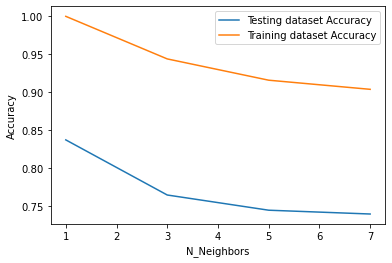

AT ALPHA =  0.85


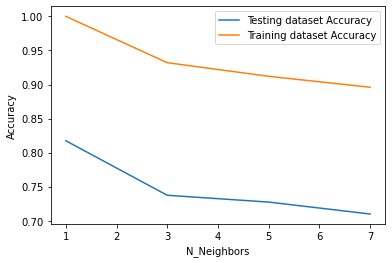

AT ALPHA =  0.9


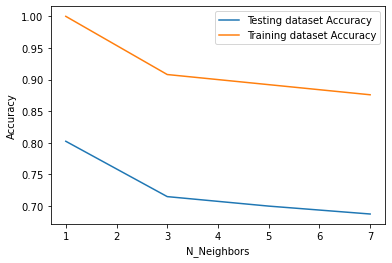

AT ALPHA =  0.95


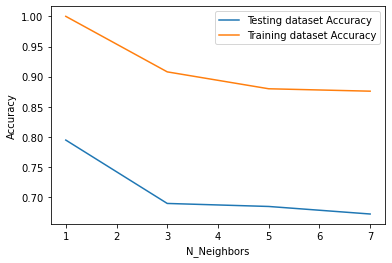

AT K=1
Alpha= 0.8 Accuracy= 0.8375
Alpha= 0.85 Accuracy= 0.8175
Alpha= 0.9 Accuracy= 0.8025
Alpha= 0.95 Accuracy= 0.795


,alpha=0.8,alpha=0.85,alpha=0.9,alpha=0.95,True Label
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,1,1,1
8,1,1,1,1,1
9,1,1,1,1,1


In [31]:
predection_50,acc_50=pcaSolution(Dtrain_50, Dtest_50,Ltrain_50,Ltest_50,alpha)
predection_50

**LDA Solution**

[[-0.00680308 -0.01211855]
 [-0.00701364 -0.01252215]
 [-0.00686499 -0.01223484]
 ...
 [ 0.01204748 -0.01195401]
 [ 0.00507676 -0.00503605]
 [-0.00518036  0.00514105]]


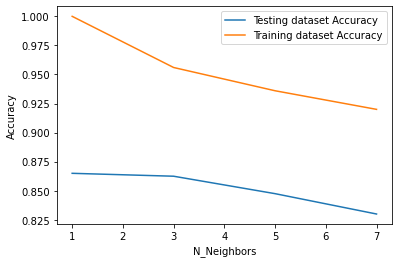

Accuracy=  0.865


,Prediction,True Label
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [32]:
pred_50,accuracy_50=ldaSolution(Dtrain_50, Dtest_50,Ltrain_50,Ltest_50,200,0)
pred_50

**Accuracy VS NonFace Image**

**PCA**

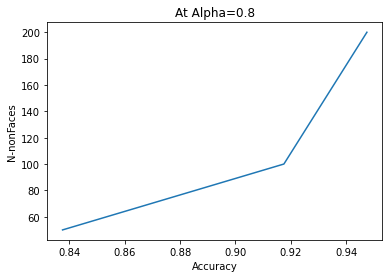

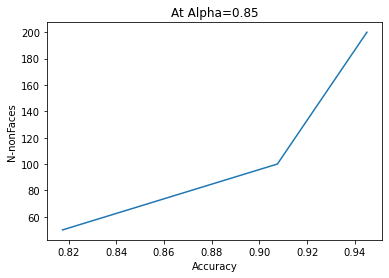

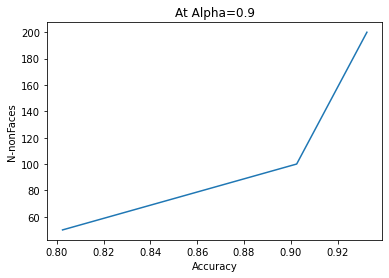

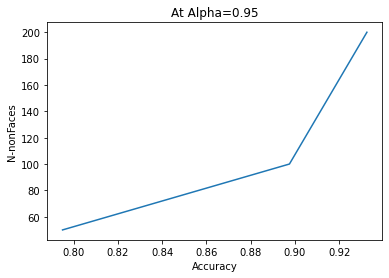

In [33]:
plot([acc_200[0],acc_100[0],acc_50[0]],0.80)
plot([acc_200[1],acc_100[1],acc_50[1]],0.85)
plot([acc_200[2],acc_100[2],acc_50[2]],0.90)
plot([acc_200[3],acc_100[3],acc_50[3]],0.95)

As We Can See Above When NonFace DataSet For Training Decrease The Accuracy Also Decrease

**LDA**

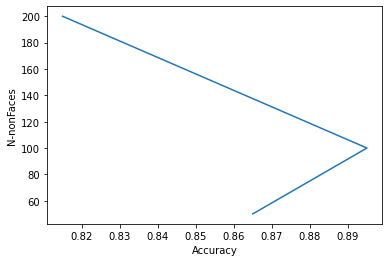

In [34]:
plot([accuracy_200,accuracy_100,accuracy_50],0)